In [1]:
# Clone our GitHub repository into the Colab environment
!git clone https://github.com/GSebs/ml-health-forecasting-transformer.git

%cd ml-health-forecasting-transformer

!pip install -r requirements.txt

fatal: destination path 'ml-health-forecasting-transformer' already exists and is not an empty directory.
/content/ml-health-forecasting-transformer


In [2]:
import torch
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset 
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

In [3]:
DATA_DIR = 'data'
ARTIFACTS_DIR = os.path.join(DATA_DIR,'artifacts') 
#instead of feeding the gpu the entire sequence at once, we break it down into batch sizes of 64
#preventing memory overload on the GPU
BATCH_SIZE = 64

X_train = np.load(os.path.join(ARTIFACTS_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(ARTIFACTS_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(ARTIFACTS_DIR,'X_val.npy'))
y_val = np.load(os.path.join(ARTIFACTS_DIR, 'y_val.npy'))

In [4]:
'''
NNs in pytorch can't read numpy arrays so we have to covert them into tensors 
gpus are optimized for float32 to make training faster 
and fit larger models (but numpy arrays default to float64 which takes 2x the memory)
so we have to specify the dtype when converting to tensors
'''

train_features = torch.tensor(X_train, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
val_features = torch.tensor(X_val, dtype=torch.float32)
val_targets = torch.tensor(y_val,dtype=torch.float32)

#TensorDataset acts as a zipper to link features and targets together so when we shuffle the features and targets stay aligned
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)

#We use DataLoader to feed the data into the model in batches
#Specifcally we are able to send chunks of the data and shuffel up the cycles randomly for each engine to prevent overfitting
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) #No need to shuffle validation data to its easier to visualize preformance

print(f"Data loaded. Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

Data loaded. Training batches: 222, Validation batches: 56


In [ ]:
'''
create the LSTM model

this is a type of RNN but keeps track of long term dependencies better than vanilla RNNs
'''
class LSTMBaseline(pl.LightningModule): #inherits from pytorch lightning module
    def __init__(self, input_dim, hidden_dim=50, num_layers=2, output_dim=1, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters() #save all params passed in init in self.hparams

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) #define the LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) #creates a linnear connection layer from the LSTM hidden layer to the output
        self.criterion = nn.MSELoss() #since this is a regression problem we use mean squared error as our loss function
        
    def forward(self, x):
        out, _ = self.lstm(x) #pass our input into the LSTM layer 
        last_out = out[:, -1, :] #get the output of the last time step (all features values at the last time step as a 2D tensor)
        prediction = self.fc(last_out) #to get our prediction RUL values we pass the last output through the linear layer to compress it down to 1 preduction value

        return prediction
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x) #call the forward function to get y_pred

        loss = self.criterion(y_pred, y.view(-1,1)) #calculate the loss between predicted and actual RUL values
        self.log('train_loss', loss)

        return loss #now the optimizer can use this loss to update the model weights
    
    #does the same thing as training step but for validation data (data the model hasn't seen before)
    #also we don't update weights for the validation step
    def validation_step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x)

        loss = self.criterion(y_pred, y.view(-1,1))
        self.log('val_loss', loss)

        return loss
    

    '''
    the optimizer we are using is Adam
    Adam adaptively picks learning rates for each parameter during training and uses momentum to speed up training
    Adam is able to converge faster for a complex model like an LSTM
    '''
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [6]:
from pytorch_lightning.loggers import CSVLogger


input_dim = X_train.shape[2] 


model = LSTMBaseline(input_dim=input_dim)


csv_logger = CSVLogger("training_logs", name="lstm_baseline") #logger object that saves logs in csv format to training_logs/lstm_baseline


#allows us to train on a gpu (A100 connected throguh google colab pro)
trainer = pl.Trainer(
    max_epochs=20, 
    accelerator='gpu', 
    devices=1,
    enable_progress_bar=True,
    logger=csv_logger 
)

#start training the model
print("Starting Baseline Training with CSV Logging...")
trainer.fit(model, train_loader, val_loader)
print("Training Complete.")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Con

Starting Baseline Training with CSV Logging...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm      │ LSTM    │ 34.2 K │ train │     0 │
│ 1 │ fc        │ Linear  │     51 │ train │     0 │
│ 2 │ criterion │ MSELoss │      0 │ train │     0 │
└───┴───────────┴─────────┴────────┴───────┴───────┘

Trainable params: 34.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 34.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Training Complete.


Loading metrics from: training_logs/lstm_baseline/version_0/metrics.csv


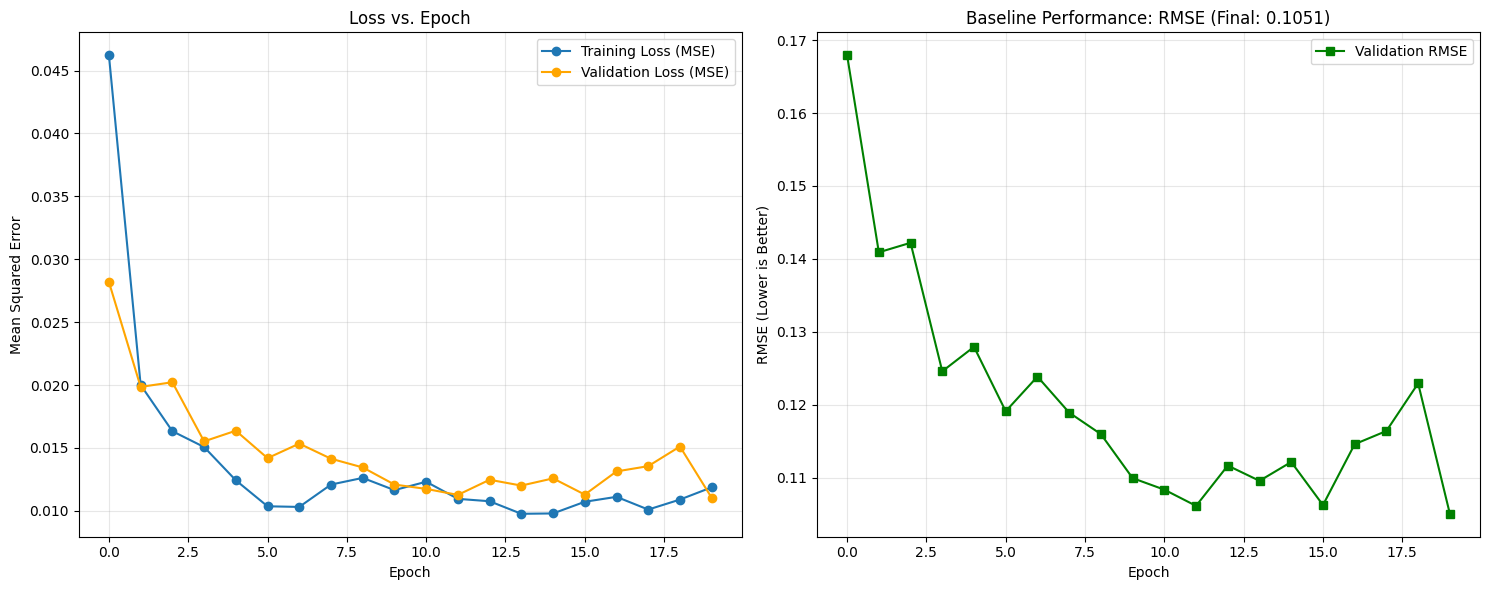

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob


log_dir = 'training_logs/lstm_baseline'


versions = glob.glob(os.path.join(log_dir, 'version_*'))

if len(versions) > 0:

    latest_version = max(versions, key=os.path.getmtime)
    metrics_path = os.path.join(latest_version, 'metrics.csv')
    print(f"Loading metrics from: {metrics_path}")
    

    metrics_df = pd.read_csv(metrics_path)
    

    epoch_metrics = metrics_df.groupby('epoch').mean().reset_index()
    

    if 'val_loss' in epoch_metrics.columns:
        epoch_metrics['val_rmse'] = epoch_metrics['val_loss'] ** 0.5
    

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    if 'train_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics['epoch'], epoch_metrics['train_loss'], label='Training Loss (MSE)', marker='o')
    if 'val_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics['epoch'], epoch_metrics['val_loss'], label='Validation Loss (MSE)', marker='o', color='orange')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 2, 2)
    if 'val_rmse' in epoch_metrics.columns:
        plt.plot(epoch_metrics['epoch'], epoch_metrics['val_rmse'], label='Validation RMSE', color='green', marker='s')
        final_rmse = epoch_metrics['val_rmse'].iloc[-1]
        plt.title(f'Baseline Performance: RMSE (Final: {final_rmse:.4f})')
    else:
        plt.title('RMSE Not Available')
        
    plt.xlabel('Epoch')
    plt.ylabel('RMSE (Lower is Better)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
else:
    print(f"No logs found in {log_dir}. Did you run the training cell above?")